# Premise

Who we are: Aqua Partners - Public Sector Consulting Firm specialized in economic development

Stakeholder: Tanzanian Government

Objective: Assist the government in improving the funcitonality of future waterpumps installed in the country using the existing range of infrastructure 

Dataset: Status and features of waterpumps installed in Tanzania to provide water supply to cities / villages



# Definitions 

amount_tsh - Total static head (amount water available to waterpoint) / date_recorded - The date the row was entered

funder - Who funded the well / gps_height - Altitude of the well

installer - Organization that installed the well / longitude - GPS coordinate 

latitude - GPS coordinate / wpt_name - Name of the waterpoint if there is one

basin - Geographic water basin / subvillage - Geographic location / region - Geographic location

region_code - Geographic location (coded)/ district_code - Geographic location (coded)

lga - Geographic location / ward - Geographic location /population - Population around the well

public_meeting - True/False / recorded_by - Group entering this row of data / scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint / permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed / extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses / extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed / management_group - How the waterpoint is managed

payment - What the water costs / payment_type - What the water costs

water_quality - The quality of the water / quality_group - The quality of the water

quantity - The quantity of water / quantity_group - The quantity of water

source - The source of the water / source_type - The source of the water

source_class - The source of the water / waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

# Package Installation

In [70]:
import pandas as pd
import numpy as np
import geopandas as geo
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from ml_repo import scores
from ml_repo import roc_plot
from ml_repo import annot
from ml_repo import plotfeatures
from ml_repo import print_metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score


# Dataset

The labels in this dataset are simple. There are three possible values:
functional - the waterpoint is operational and there are no repairs needed
functional needs repair - the waterpoint is operational, but needs repairs
non functional - the waterpoint is not operational

In [81]:
X = pd.read_csv('Data/X.csv')
y = pd.read_csv('Data/Y.csv')
X1 = pd.read_csv('Data/X1.csv')
df = pd.merge(y,X,on='id')

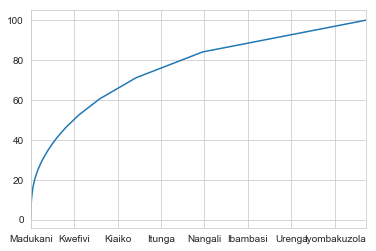

In [82]:
(df.subvillage.value_counts(normalize = True)*100).cumsum().plot()

In [83]:
df['installer'].fillna('other', inplace = True)
df['funder'].fillna('other', inplace = True)
df['public_meeting'].fillna('False', inplace = True)
df['scheme_management'].fillna('other',inplace = True)
df['permit'].fillna('False', inplace = True)
df.drop(columns =['recorded_by', 'extraction_type_group','extraction_type_class', 'payment', 'quantity_group', 'source', 'source_class', 'id', 'num_private', 'quantity_group','waterpoint_type_group', 'wpt_name', 'scheme_name', 'amount_tsh'], inplace = True)
df['region_and_code'] = df['region'] + df['region_code'].map(str)
df.drop(columns = ['region', 'region_code'], inplace = True)
df.population.replace(0,df.groupby(['district_code']).population.mean(), inplace = True)
df.status_group.replace('functional needs repair','non functional', inplace = True)

In [84]:
i = df.construction_year.median()
df.construction_year.replace(0,i,inplace=True)

j = df.groupby(['basin']).gps_height.mean()
df.gps_height.replace(0,j, inplace = True)



In [85]:
df.status_group

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

In [86]:
df['year'] = df.date_recorded.str[:4]
df['month'] = df.date_recorded.str[-4]
df.drop(columns = ['date_recorded'], inplace = True)
df['length_operation'] = df.year.map(int) - df.construction_year.map(int)

In [87]:
cols = [i for i in df.columns if type(df[i].iloc[0]) == str]
df[cols] = df[cols].where(df[cols].apply(lambda x: x.map(x.value_counts())) > 50,"other")

In [88]:
df.nunique()

status_group             2
funder                 143
gps_height            2428
installer              144
longitude            57516
latitude             57517
basin                    9
subvillage              61
district_code           20
lga                    124
ward                   309
population            1056
public_meeting           3
scheme_management       12
permit                   3
construction_year       54
extraction_type         15
management              12
management_group         5
payment_type             7
water_quality            8
quality_group            6
quantity                 5
source_type              7
waterpoint_type          6
region_and_code         28
year                     4
month                   10
length_operation        60
dtype: int64

# Data Transformation

In [89]:
scaler = MinMaxScaler()
conti = df.loc[:,['population', 'gps_height', 'length_operation']]
df[['population', 'gps_height', 'length_operation']] = scaler.fit_transform(df[['population', 'gps_height', 'length_operation']])
df

status_group           funder  gps_height     installer  longitude  \
0          functional            Roman    0.517483         Roman  34.938093   
1          functional          Grumeti    0.520629         other  34.698766   
2          functional            other    0.271329  World vision  37.460664   
3      non functional           Unicef    0.123427        UNICEF  38.486161   
4          functional            other    0.031469       Artisan  31.130847   
...               ...              ...         ...           ...        ...   
59395      functional  Germany Republi    0.454545           CES  37.169807   
59396      functional            other    0.455245         other  35.249991   
59397      functional            other    0.031469         other  34.017087   
59398      functional            other    0.031469         other  35.861315   
59399      functional       World Bank    0.098252         World  38.104048   

        latitude                    basin subvillage  district_code  \
0      -9.856322               Lake Nyasa      other              5   
1      -2.147466            Lake Victoria      other              2   
2      -3.821329                  Pangani    Majengo              4   
3     -11.155298  Ruvuma / Southern Coast      other             63   
4      -1.825359            Lake Victoria      other              1   
...          ...                      ...        ...            ...   
59395  -3.253847                  Pangani      other              5   
59396  -9.070629                   Rufiji      other              4   
59397  -8.750434                   Rufiji      other              7   
59398  -6.378573                   Rufiji      other              4   
59399  -6.747464              Wami / Ruvu      other              2   

                  lga  ... payment_type  water_quality quality_group  \
0              Ludewa  ...     annually           soft          good   
1           Serengeti  ...    never pay           soft          good   
2           Simanjiro  ...   per bucket           soft          good   
3            Nanyumbu  ...    never pay           soft          good   
4             Karagwe  ...    never pay           soft          good   
...               ...  ...          ...            ...           ...   
59395             Hai  ...   per bucket           soft          good   
59396          Njombe  ...     annually           soft          good   
59397         Mbarali  ...      monthly       fluoride      fluoride   
59398        Chamwino  ...    never pay           soft          good   
59399  Morogoro Rural  ...   on failure          salty         salty   

           quantity           source_type              waterpoint_type  \
0            enough                spring           communal standpipe   
1      insufficient  rainwater harvesting           communal standpipe   
2            enough                   dam  communal standpipe multiple   
3               dry              borehole  communal standpipe multiple   
4          seasonal  rainwater harvesting           communal standpipe   
...             ...                   ...                          ...   
59395        enough                spring           communal standpipe   
59396        enough            river/lake           communal standpipe   
59397        enough              borehole                    hand pump   
59398  insufficient          shallow well                    hand pump   
59399        enough          shallow well                    hand pump   

      region_and_code  year month length_operation  
0            Iringa11  2011     3         0.316667  
1              Mara20  2013     3         0.166667  
2           Manyara21  2013     2         0.183333  
3            Mtwara90  2013     1         0.566667  
4            Kagera18  2011     7         0.533333  
...               ...   ...   ...              ...  
59395    Kilimanjaro3  2013     5         0.350000  
59396        Iringa11  2011  

In [90]:
df.columns

Index(['status_group', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code', 'year',
       'month', 'length_operation'],
      dtype='object')

In [91]:
y = df['status_group']

X = df.loc[:, ['funder', 'gps_height', 'installer',
       'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code', 'year',
       'month', 'length_operation']]

X1 = pd.get_dummies(X, prefix = ['funder', 'installer',
       'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code'])

y1 = pd.get_dummies(y, prefix = ['status_group'])
y1 = y1.iloc[:,0]
X1.shape

(59400, 926)

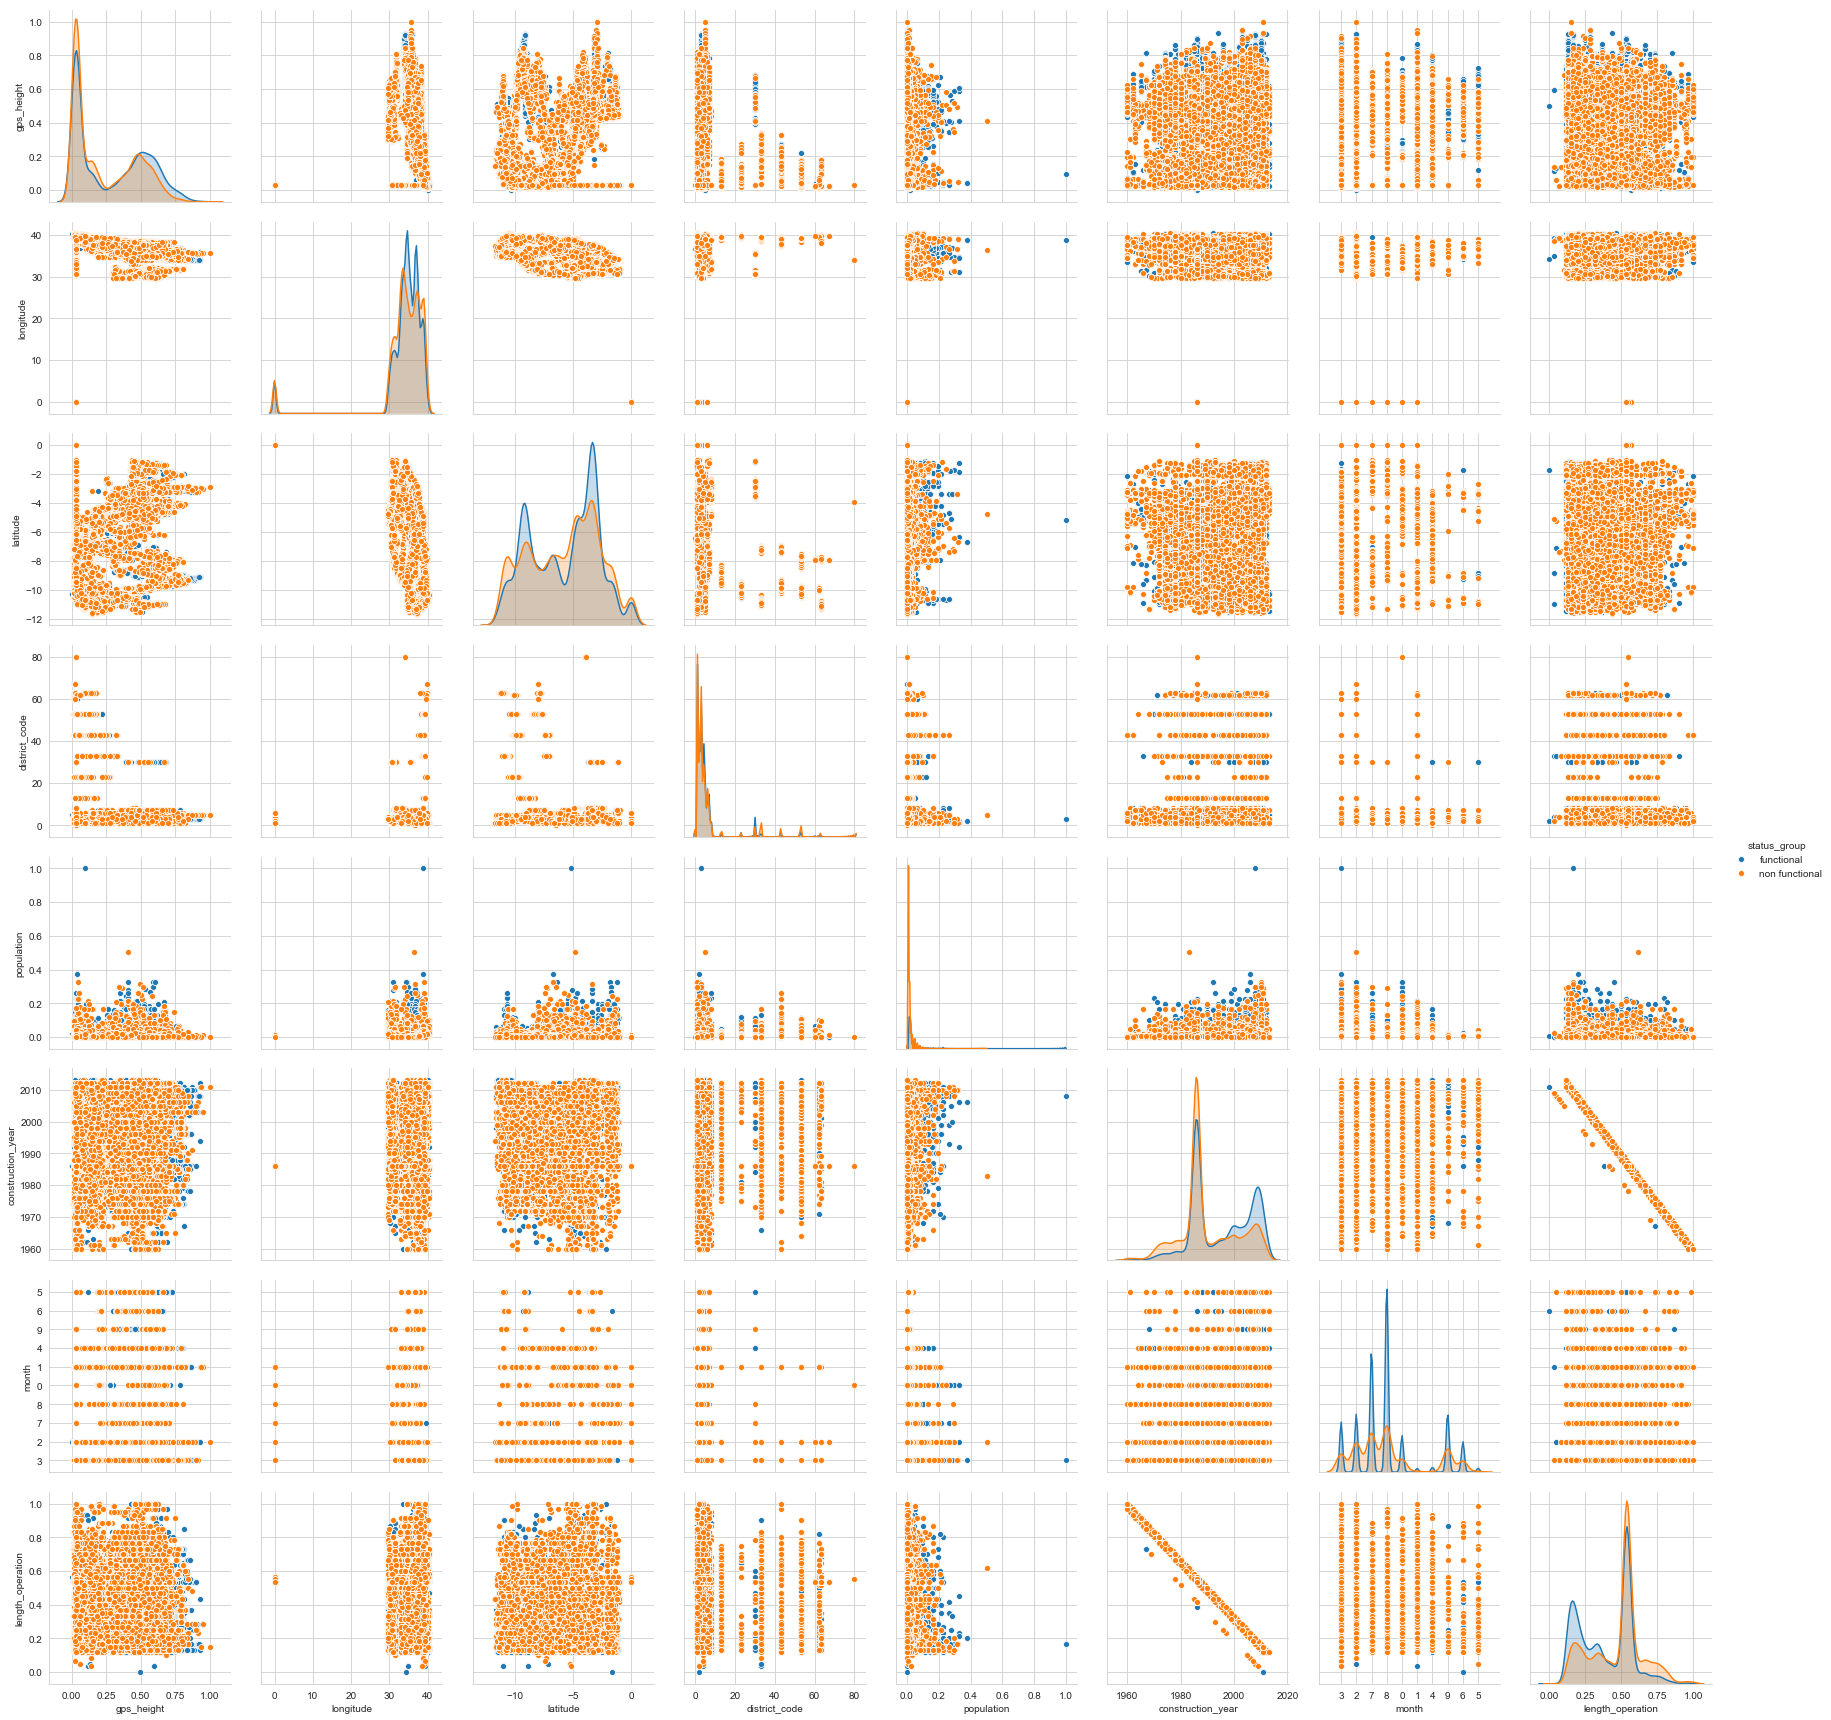

In [92]:
plt.close();
sns.set_style("whitegrid");
sns.pairplot(df, hue="status_group", size=3);
plt.show()

# Initial split of DataSet (Train / Test set)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42) 
skf = StratifiedKFold(n_splits=5,random_state=42)

# Overall Baseline Model - Decision Tree

## Baseline method

train: 1.0 test: 0.8


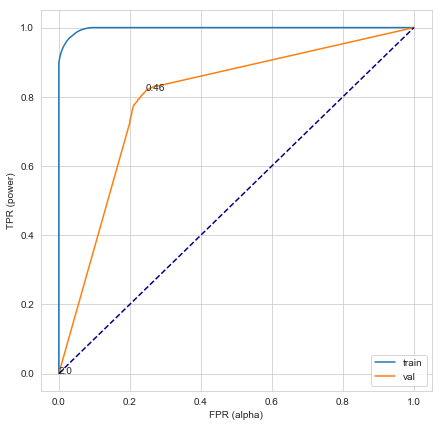

CPU times: user 4.99 s, sys: 832 ms, total: 5.82 s
Wall time: 6.24 s


In [94]:
%%time

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

In [95]:
%%time
clf = DecisionTreeClassifier()
param_grid = {'criterion':['gini','entropy'], 'max_depth': [2,3,4], 'min_samples_leaf':[1500, 2000, 2500]}
gs = GridSearchCV(clf, param_grid, cv = skf)

gs.fit(X_train, y_train)
gs.best_params_

CPU times: user 51.9 s, sys: 23.5 s, total: 1min 15s
Wall time: 1min 17s


{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1500}

In [96]:
y_preds = gs.predict(X_train)
print('Accuracy: ', accuracy_score(y_train, y_preds))

Accuracy:  0.7145675505050505


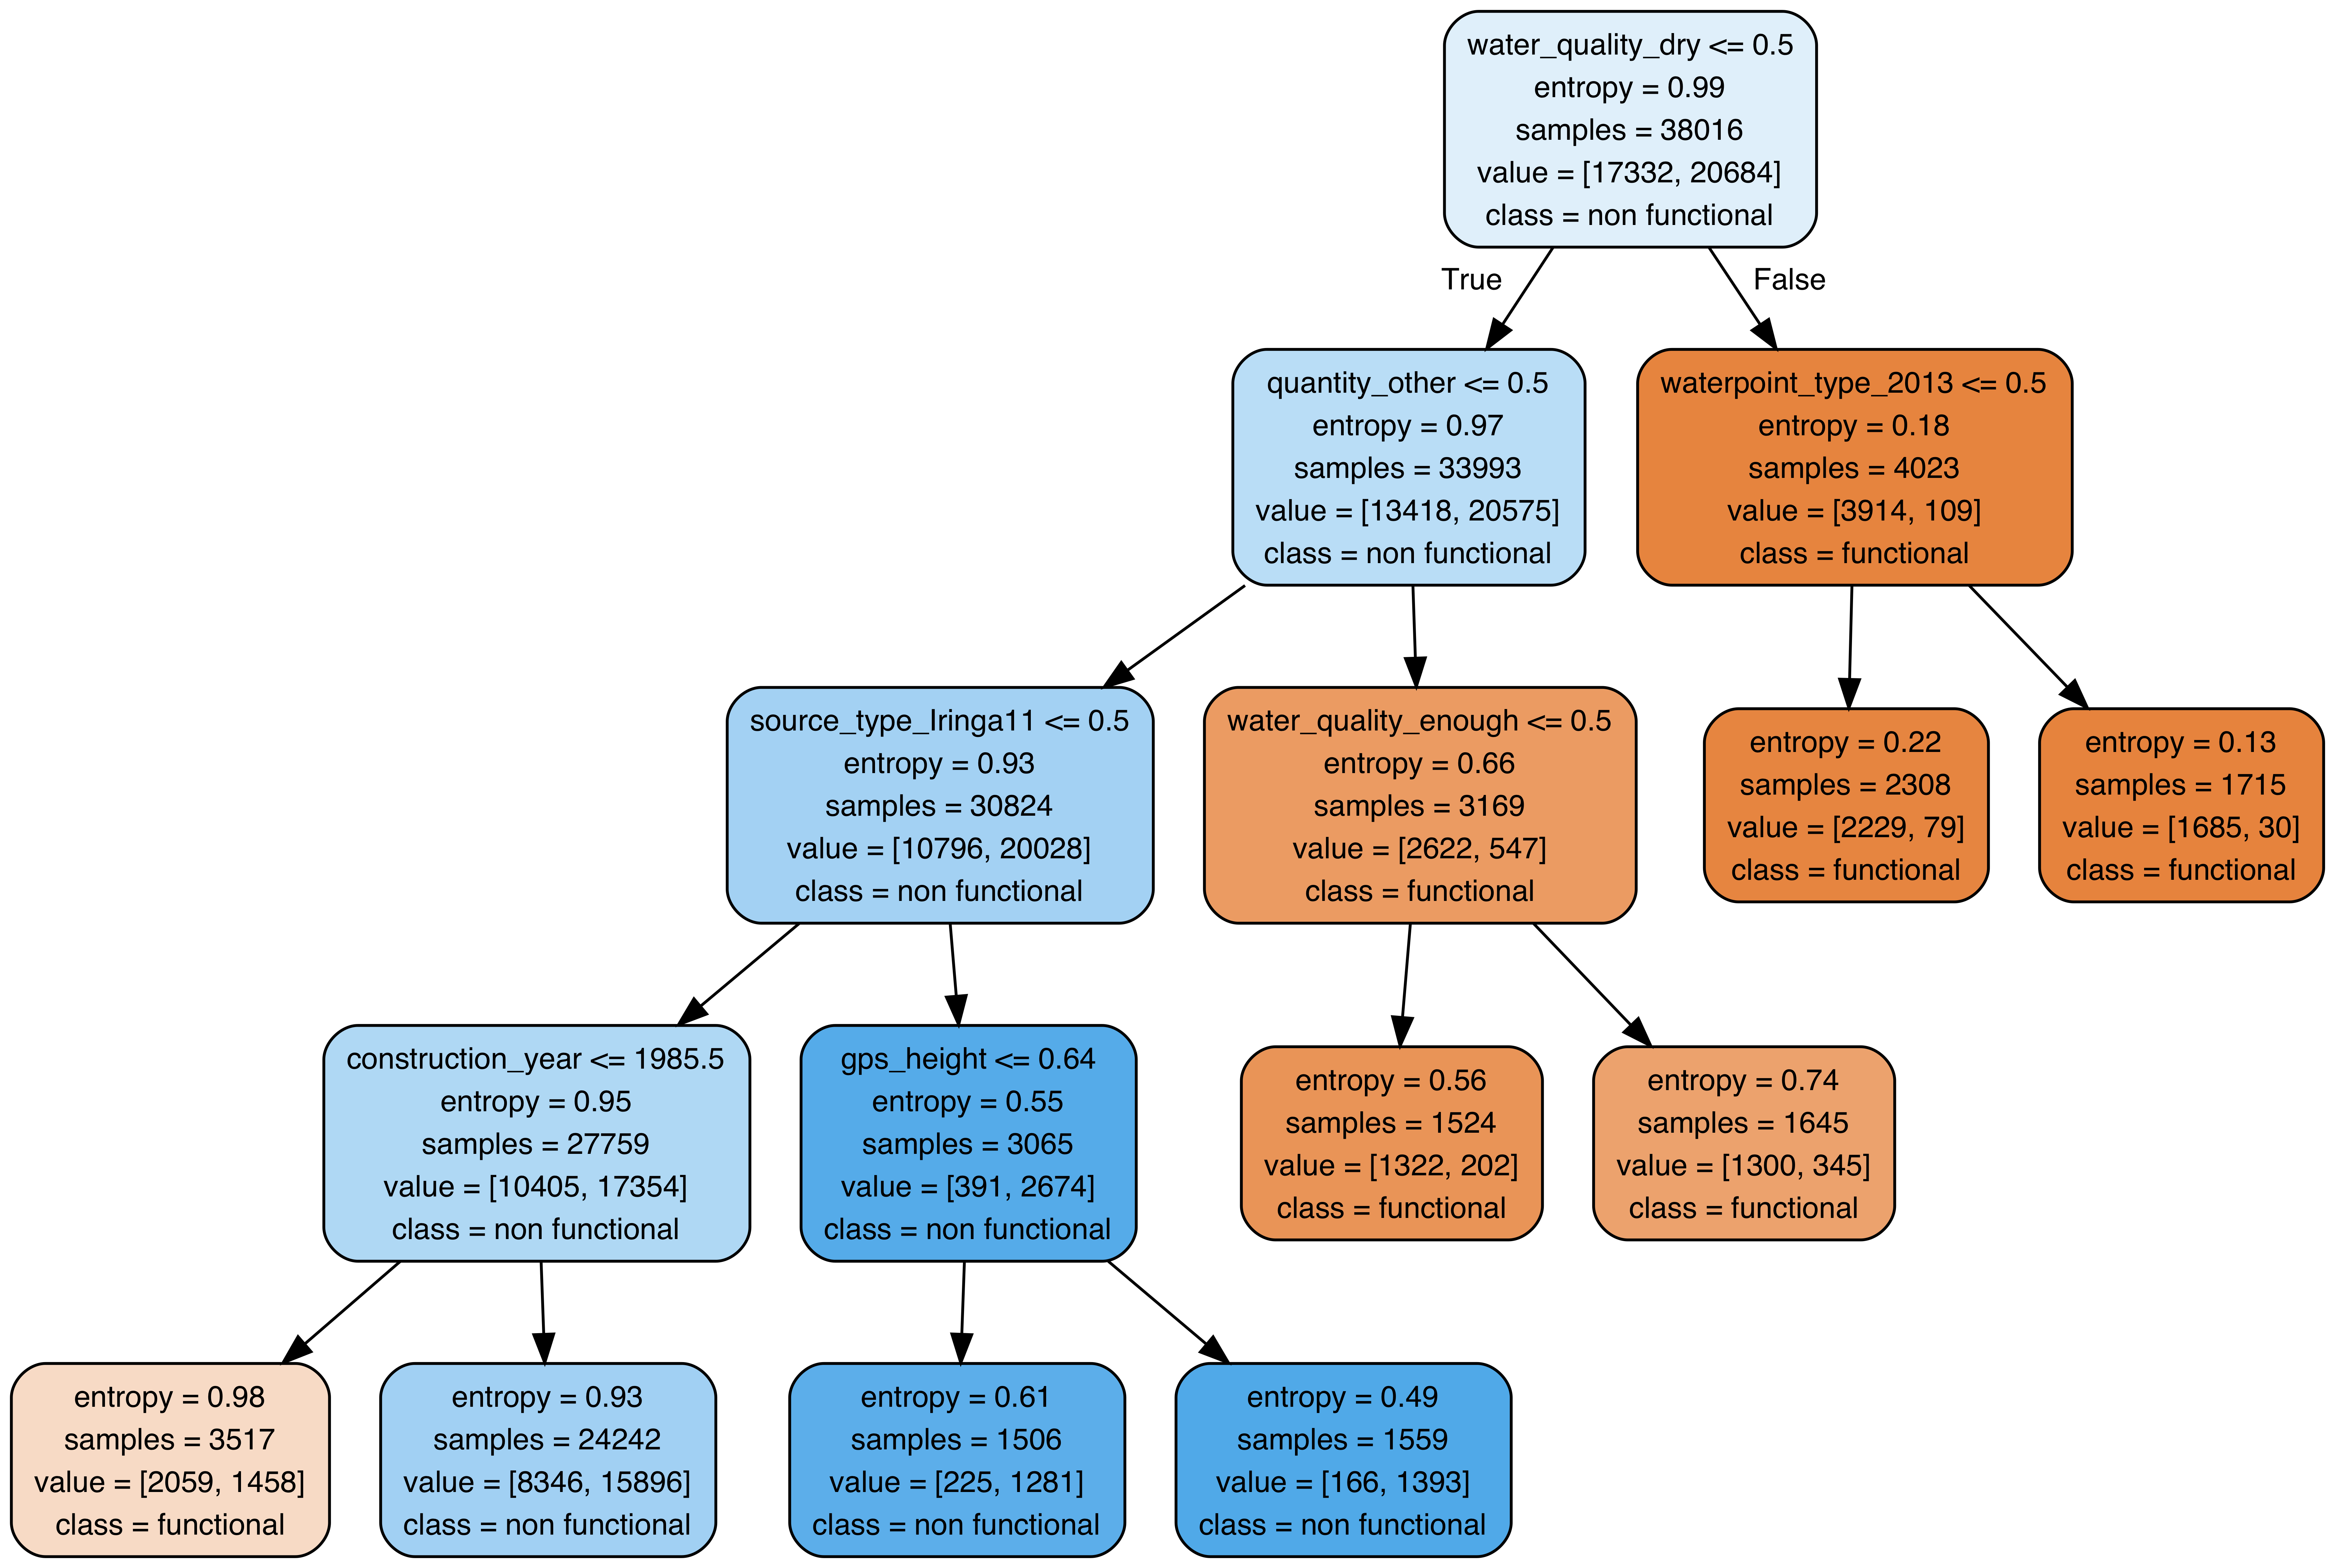

In [97]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 4, min_samples_leaf = 1500)
clf.fit(X_train, y_train) #encoded categorical variable using pd.get_dummies()

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = np.unique(y).astype(str),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png 
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Enhanced Method - Bagging

# Model - Logistic Regression 

## Baseline method

In [58]:
%%time

logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

CPU times: user 1.36 s, sys: 277 ms, total: 1.64 s
Wall time: 1.68 s


LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [59]:
train_prob = model_log.predict_proba(X_train)[:,1]
val_prob = model_log.predict_proba(X_val)[:,1]

In [113]:
from sklearn.metrics import roc_auc_score
train = roc_auc_score(y_train,train_prob)
val = roc_auc_score(y_val,val_prob)
print('train: roc_auc_score: ', round(train,2),'//',"validation roc_auc_score: ", round(val,2))

train: roc_auc_score:  0.87 // validation roc_auc_score:  0.86


In [114]:
scores(model_log,X_train,X_val,y_train,y_val)
roc_plot(model_log,X_train,y_train,X_val,y_val)

train: 0.87 test: 0.86


In [57]:
y_pred_log = model_log.predict(X_train)
y_pred_log_v = model_log.predict(X_val)
print(classification_report(y_train, y_pred_log), classification_report(y_val, y_pred_log_v))

              precision    recall  f1-score   support

           0       0.80      0.71      0.76     17332
           1       0.78      0.85      0.82     20684

   micro avg       0.79      0.79      0.79     38016
   macro avg       0.79      0.78      0.79     38016
weighted avg       0.79      0.79      0.79     38016
               precision    recall  f1-score   support

           0       0.81      0.71      0.76      4386
           1       0.78      0.86      0.82      5118

   micro avg       0.79      0.79      0.79      9504
   macro avg       0.80      0.79      0.79      9504
weighted avg       0.79      0.79      0.79      9504



## Enhanced method - Bagging

In [109]:
bagging_logit = BaggingClassifier(model_log)
bagging_logit.fit(X_train, y_train)
bagging_logit.predict


<bound method BaggingClassifier.predict of BaggingClassifier(base_estimator=LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)>

In [115]:
print ('train roc_auc_score:', bagging_logit.score(X_train, y_train),'//','val roc_auc_score:', bagging_logit.score(X_val, y_val))

train roc_auc_score: 0.7895096801346801 // val roc_auc_score: 0.7882996632996633


In [111]:
scores(bagging_logit,X_train,X_val,y_train,y_val)
roc_plot(bagging_logit,X_train,y_train,X_val,y_val)

train: 0.87 test: 0.86


In [55]:
y_pred = bagging_logit.predict(X_train)
y_pred_v = bagging_logit.predict(X_val)
print(classification_report(y_train, y_pred), classification_report(y_val, y_pred_v))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74     17332
           1       0.77      0.82      0.79     20684

   micro avg       0.77      0.77      0.77     38016
   macro avg       0.77      0.76      0.76     38016
weighted avg       0.77      0.77      0.77     38016
               precision    recall  f1-score   support

           0       0.83      0.75      0.79      4386
           1       0.80      0.87      0.84      5118

   micro avg       0.82      0.82      0.82      9504
   macro avg       0.82      0.81      0.81      9504
weighted avg       0.82      0.82      0.81      9504



# Model - Random Forest

In [22]:
forest = RandomForestClassifier(n_estimators = 500, max_depth = 10)
forest.fit(X_train, y_train)
forest.fit(X_val, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
print('train accuracy:',forest.score(X_train, y_train),'//','validation accuracy:',forest.score(X_val, y_val))

train accuracy: 0.7610742845117845 // validation accuracy: 0.7926136363636364


In [24]:
y_pred = forest.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69     17332
           1       0.72      0.91      0.81     20684

    accuracy                           0.76     38016
   macro avg       0.78      0.75      0.75     38016
weighted avg       0.78      0.76      0.75     38016



# Model - Support Vector Machines

In [29]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

svm_linear = LinearSVC()


In [31]:


param_grid = {'C': [0.001, 0.01, 0.1, 1.0], 'class_weight':[None, 'balanced']}

gs_svm_linear = GridSearchCV(svm_linear, param_grid, cv=skf)


In [33]:
gs_svm_linear.fit(X_train, y_train)

gs_svm_linear.best_params_

{'C': 0.001, 'class_weight': None}

In [34]:
svm_best = LinearSVC(C=0.001,class_weight = None)

svm_best.fit(X_train,y_train)

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [35]:
print('train accuracy:',svm_best.score(X_train, y_train),'//','validation accuracy:',svm_best.score(X_val, y_val))

train accuracy: 0.6951020622895623 // validation accuracy: 0.6980218855218855


In [36]:
svmodel = SVC(kernel='rbf')
param_grid = {'C': [0.001, 0.01, 0.1, 1.0], 'class_weight':[None, 'balanced']}

gs_svmodel = GridSearchCV(svmodel, param_grid, cv=skf)



In [ ]:
gs_svmodel.fit(X_train,y_train)
gs_svmodel.best_params_

# Model - K-Nearest-Neighbors

In [14]:
neigh = KNeighborsClassifier(n_neighbors = 1000, metric = "hamming", leaf_size = 10000)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=10000, metric='hamming',
           metric_params=None, n_jobs=None, n_neighbors=1000, p=2,
           weights='uniform')

In [ ]:
neigh.score(X_train, y_train)